In [366]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.cluster import KMeans
pd.set_option('display.max_columns', 150)

In [3]:
# Cargamos los datos
df = pd.read_csv('ds_challenge_data_2022.csv', encoding='latin')
print(df.shape)
display(df.head(1))

(26975, 16)


,transaction_id,user_id,género,linea_tc,interes_tc,monto,fecha,hora,dispositivo,establecimiento,ciudad,status_txn,is_prime,dcto,cashback,fraude
0,1,573,M,87000,56,581.03,02/01/20,0,"{'año': 2019, 'marca': 'Apple', 'proveedor': '...",Farmacia,Ciudad de México,Aceptada,False,0.0,17.43,False


In [4]:
# Dividimos la columna de dispositivo en 3 columnas y renombramos columnas por comodidad
df['dispositivo_anio'] = df.dispositivo.apply(lambda l: int(str(l).split(',')[0].split(':')[1].replace("'","")))
df['dispositivo_marca'] = df.dispositivo.apply(lambda l: str(l).split(',')[1].split(':')[1].replace("'","").replace(' ','') )
df['dispositivo_proveedor'] = df.dispositivo.apply(lambda l: str(l).split(',')[2].split(':')[1].replace("'","").replace('}','').replace(' ',''))

df = df.rename(columns={'género':'genero'})
print(df.shape)
display(df.head(1))

(26975, 19)


,transaction_id,user_id,genero,linea_tc,interes_tc,monto,fecha,hora,dispositivo,establecimiento,ciudad,status_txn,is_prime,dcto,cashback,fraude,dispositivo_anio,dispositivo_marca,dispositivo_proveedor
0,1,573,M,87000,56,581.03,02/01/20,0,"{'año': 2019, 'marca': 'Apple', 'proveedor': '...",Farmacia,Ciudad de México,Aceptada,False,0.0,17.43,False,2019,Apple,Telcel


# Datos por usuarios

In [5]:
df.loc[df.ciudad.isnull(), 'ciudad'] = 'null'
df.loc[df.establecimiento.isnull(), 'establecimiento'] = 'null'

df.loc[df.ciudad == 'Ciudad de México','ciudad'] = 'cdmx'
df.loc[df.ciudad == 'Cancún','ciudad'] = 'cancun'
df.loc[df.ciudad == 'Tijuana','ciudad'] = 'tijuana'
df.loc[df.ciudad == 'Monterrey','ciudad'] = 'monterrey'
df.loc[df.ciudad == 'Toluca','ciudad'] = 'toluca'
df.loc[df.ciudad == 'Guadalajara','ciudad'] = 'guadalajara'
df.loc[df.ciudad == 'Nezahualcóyotl','ciudad'] = 'neza'

df.loc[df.establecimiento == 'Farmacia','establecimiento'] = 'farmacia'
df.loc[df.establecimiento == 'Tienda departamental','establecimiento'] = 'departamental'
df.loc[df.establecimiento == 'Abarrotes','establecimiento'] = 'abarrotes'
df.loc[df.establecimiento == 'Supermercado','establecimiento'] = 'supermercado'
df.loc[df.establecimiento == 'Compra en línea','establecimiento'] = 'linea'


In [6]:
usuarios = df.copy()

usuarios.loc[usuarios.ciudad.isnull(), 'ciudad'] = 'null'

usuarios['momento_de_dia'] = 0
usuarios.loc[(usuarios.hora > 6)&(usuarios.hora <= 12) ,'momento_de_dia'] = 'maniana'
usuarios.loc[(usuarios.hora > 12)&(usuarios.hora <= 20) ,'momento_de_dia'] = 'tarde'
usuarios.loc[(usuarios.hora > 20)|(usuarios.hora <= 6) ,'momento_de_dia'] = 'noche'

print(usuarios.shape)
print(usuarios[usuarios.momento_de_dia ==0].shape[0])
print(usuarios.momento_de_dia.value_counts())

(26975, 20)
0
tarde      12197
maniana     8452
noche       6326
Name: momento_de_dia, dtype: int64


In [7]:
usuarios['fraudes'] =usuarios['fraude']
usuarios['monto_std'] = usuarios['monto']
usuarios['monto_maximo'] = usuarios['monto']
usuarios['monto_minimo'] = usuarios['monto']
usuarios['linea_tc_unico'] = usuarios['linea_tc']
usuarios['interes_tc_unico'] = usuarios['interes_tc']


In [8]:
usuarios_desc = usuarios.groupby(['user_id','is_prime'],as_index=False).agg({
    'genero':max,
    'ciudad':'nunique',
    'establecimiento':'nunique',
    'linea_tc_unico':'nunique',
    'linea_tc':max,
    'interes_tc':max,
    'transaction_id':'count',
    'fraudes':sum,
    'fraude':max,
    'monto':'mean',
    'monto_std':'std',
    'monto_maximo':max,
    'monto_minimo':min,
    'dispositivo_marca':'nunique',
    'dispositivo_anio':'nunique',
    'dispositivo_proveedor':'nunique',
    
})
print(usuarios.shape)
display(usuarios.head(1))

(26975, 26)


,transaction_id,user_id,genero,linea_tc,interes_tc,monto,fecha,hora,dispositivo,establecimiento,ciudad,status_txn,is_prime,dcto,cashback,fraude,dispositivo_anio,dispositivo_marca,dispositivo_proveedor,momento_de_dia,fraudes,monto_std,monto_maximo,monto_minimo,linea_tc_unico,interes_tc_unico
0,1,573,M,87000,56,581.03,02/01/20,0,"{'año': 2019, 'marca': 'Apple', 'proveedor': '...",farmacia,cdmx,Aceptada,False,0.0,17.43,False,2019,Apple,Telcel,noche,False,581.03,581.03,581.03,87000,56


## Fraudes por género

In [9]:
print('Número de usuarios con Fraudes: ', usuarios_desc[usuarios_desc.fraude == True].shape[0])
print('Número de fraudes por usuario: ', usuarios_desc[(usuarios_desc.fraude == True)].fraudes.value_counts())

Número de usuarios con Fraudes:  675
Número de fraudes por usuario:  1    563
2     93
3     15
4      4
Name: fraudes, dtype: int64


In [10]:
print('Porcentaje de mujeres: ', (usuarios_desc[usuarios_desc.genero == 'F'].shape[0]/ usuarios_desc.shape[0])*100 , 'Total de mujeres: ',usuarios_desc[usuarios_desc.genero == 'F'].shape[0])
print('Porcentaje de hombres: ', (usuarios_desc[usuarios_desc.genero == 'M'].shape[0]/ usuarios_desc.shape[0])*100, 'Total de hombres: ', usuarios_desc[usuarios_desc.genero == 'M'].shape[0])
print('Porcentaje sin género definido: ', (usuarios_desc[usuarios_desc.genero == 'N'].shape[0]/ usuarios_desc.shape[0])*100, 'Total de usuarios_desc sin género identificado: ',usuarios_desc[usuarios_desc.genero == 'N'].shape[0])

Porcentaje de mujeres:  44.6 Total de mujeres:  1784
Porcentaje de hombres:  46.275 Total de hombres:  1851
Porcentaje sin género definido:  9.125 Total de usuarios_desc sin género identificado:  365


In [11]:
print('USUARIOS CON FRAUDES: ')
print('Porcentaje de mujeres: ', (usuarios_desc[(usuarios_desc.fraude==True) &(usuarios_desc.genero == 'F')].shape[0]/ usuarios_desc[usuarios_desc.fraude ==True].shape[0])*100, 'Total de mujeres: ', usuarios_desc[(usuarios_desc.fraude==True) &(usuarios_desc.genero == 'F')].shape[0])
print('Porcentaje de hombres: ', (usuarios_desc[(usuarios_desc.fraude==True) &(usuarios_desc.genero == 'M')].shape[0]/ usuarios_desc[usuarios_desc.fraude ==True].shape[0])*100, 'Total de hombres: ', usuarios_desc[(usuarios_desc.fraude==True) &(usuarios_desc.genero == 'M')].shape[0])
print('Porcentaje sin género definido: ', (usuarios_desc[(usuarios_desc.fraude==True) &(usuarios_desc.genero == 'N')].shape[0]/ usuarios_desc[usuarios_desc.fraude ==True].shape[0])*100, 'Total de usuarios_desc sin género definido: ',usuarios_desc[(usuarios_desc.fraude==True) &(usuarios_desc.genero == 'N')].shape[0])

USUARIOS CON FRAUDES: 
Porcentaje de mujeres:  45.33333333333333 Total de mujeres:  306
Porcentaje de hombres:  44.888888888888886 Total de hombres:  303
Porcentaje sin género definido:  9.777777777777779 Total de usuarios_desc sin género definido:  66


## Usuarios por ciudad

In [12]:
ciudad = usuarios_desc.groupby(['ciudad'],as_index=False).agg({'transaction_id':sum,'user_id':'count'})
ciudad['porcentaje'] = (ciudad['user_id'] /ciudad.user_id.sum())*100
ciudad_fraude = usuarios_desc[usuarios_desc.fraude == 1].groupby(['ciudad'],as_index=False).agg({'transaction_id':sum,'user_id':'count'})
ciudad_fraude['porcentaje'] = (ciudad_fraude['user_id'] /ciudad_fraude.user_id.sum())*100

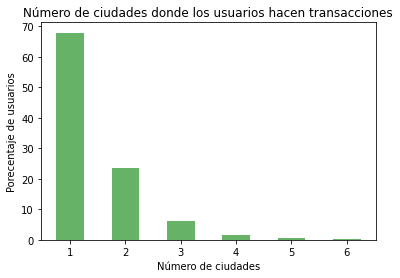

In [13]:
fig, ax = plt.subplots()
ax.bar(ciudad.ciudad.values, ciudad.porcentaje.values, color='g',alpha=0.6, width=0.5)
ax.set_ylabel('Porecentaje de usuarios')
ax.set_xlabel('Número de ciudades')

ax.set_title('Número de ciudades donde los usuarios hacen transacciones')
plt.savefig('RappiCard_usuarios_ciudad.png',format='png')

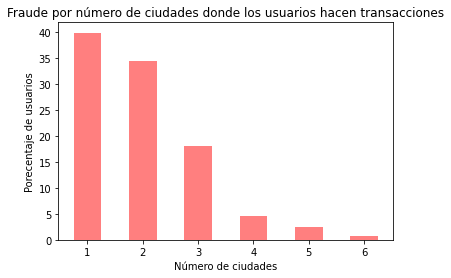

In [14]:
fig, ax = plt.subplots()
ax.bar(ciudad_fraude.ciudad.values, ciudad_fraude.porcentaje.values, color='r',alpha=0.5, width=0.5)
ax.set_ylabel('Porecentaje de usuarios')
ax.set_xlabel('Número de ciudades')

ax.set_title('Fraude por número de ciudades donde los usuarios hacen transacciones')
plt.savefig('RappiCard_usuarios_fraude_ciudad.png',format='png')

## Establecimiento

In [15]:
establecimiento = usuarios_desc.groupby(['establecimiento'],as_index=False).agg({'transaction_id':sum,'user_id':'count'})
establecimiento['porcentaje'] = (establecimiento['user_id'] /establecimiento.user_id.sum())*100
establecimiento_fraude = usuarios_desc[usuarios_desc.fraude == 1].groupby(['establecimiento'],as_index=False).agg({'transaction_id':sum,'user_id':'count'})
establecimiento_fraude['porcentaje'] = (establecimiento_fraude['user_id'] /establecimiento_fraude.user_id.sum())*100

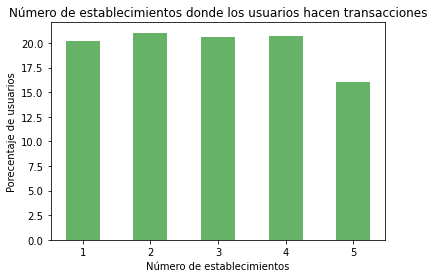

In [16]:
fig, ax = plt.subplots()
ax.bar(establecimiento[establecimiento.establecimiento != 0].establecimiento.values, establecimiento[establecimiento.establecimiento != 0].porcentaje.values, color='g',alpha=0.6, width=0.5)
ax.set_ylabel('Porecentaje de usuarios')
ax.set_xlabel('Número de establecimientos')

ax.set_title('Número de establecimientos donde los usuarios hacen transacciones')
plt.savefig('RappiCard_usuarios_establecimientos.png',format='png')

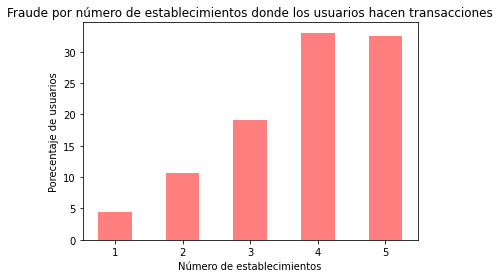

In [17]:
fig, ax = plt.subplots()
ax.bar(establecimiento_fraude[establecimiento_fraude.establecimiento != 0].establecimiento.values, establecimiento_fraude[establecimiento_fraude.establecimiento != 0].porcentaje.values, color='r',alpha=0.5, width=0.5)
ax.set_ylabel('Porecentaje de usuarios')
ax.set_xlabel('Número de establecimientos')

ax.set_title('Fraude por número de establecimientos donde los usuarios hacen transacciones')
plt.savefig('RappiCard_usuarios_fraude_establecimientos.png',format='png')

## Dispositivos

In [180]:
dispositivo = df[df.fraude ==False].groupby(['user_id','dispositivo'],as_index=False).agg({'transaction_id':'count'})
dispositivo_fraude = df[df.fraude == True].groupby(['user_id','dispositivo'],as_index=False).agg({'fraude': sum})


In [183]:
test = dispositivo_fraude.merge(dispositivo,on=['user_id','dispositivo'],how='outer')

In [212]:
test[(~test.fraude.isnull())]# &(test.transaction_id.isnull())].user_id.nunique()

,user_id,dispositivo,fraude,transaction_id
0,5,"{'año': 2014, 'marca': 'Apple', 'proveedor': '...",1.0,2.0
1,7,"{'año': 2021, 'marca': 'Motorola', 'proveedor'...",1.0,4.0
2,9,"{'año': 2016, 'marca': 'Huawei', 'proveedor': ...",1.0,8.0
3,14,"{'año': 2016, 'marca': 'Samsung', 'proveedor':...",1.0,6.0
4,19,"{'año': 2016, 'marca': 'Apple', 'proveedor': '...",1.0,NaN
...,...,...,...,...
679,3973,"{'año': 2016, 'marca': 'Samsung', 'proveedor':...",2.0,2.0
680,3980,"{'año': 2016, 'marca': 'Apple', 'proveedor': '...",1.0,6.0
681,3986,"{'año': 2017, 'marca': 'Apple', 'proveedor': '...",1.0,3.0
682,3991,"{'año': 2020, 'marca': 'Motorola', 'proveedor'...",1.0,1.0


## Caracterización usuarios

In [299]:
usuarios_descripcion = usuarios[usuarios.fraude == False].groupby(['user_id'],as_index=False).agg({
    'monto':'mean',
    'monto_std':'std',
    'transaction_id':'count',
    'ciudad':'nunique',
    'establecimiento':'nunique',
    'genero':max,
    'linea_tc':max,
    'dispositivo':'nunique'
})

In [300]:
usuarios_ciudad = usuarios[(usuarios.fraude == False) &(usuarios.ciudad != 'null')].groupby(['user_id','ciudad'],as_index=False).agg({'monto':'mean'}).pivot(columns='ciudad',index='user_id',values='monto').fillna(0).reset_index()
for col in ['cdmx','guadalajara','monterrey','neza','toluca','cancun','tijuana']:
    usuarios_ciudad = usuarios_ciudad.rename(columns={col:col+'_monto_promedio'})

usuarios_ciudad_txn = usuarios[(usuarios.fraude == False)&(usuarios.ciudad != 'null')].groupby(['user_id','ciudad'],as_index=False).agg({'transaction_id':'count'}).pivot(columns='ciudad',index='user_id',values='transaction_id').fillna(0).reset_index()
for col in ['cdmx','guadalajara','monterrey','neza','toluca','cancun','tijuana']:
    usuarios_ciudad_txn = usuarios_ciudad_txn.rename(columns={col:col+'_transacciones'})
    
usuarios_ciudad_std = usuarios[(usuarios.fraude == False)&(usuarios.ciudad != 'null')].groupby(['user_id','ciudad'],as_index=False).agg({'monto_std':'std'}).pivot(columns='ciudad',index='user_id',values='monto_std').fillna(0).reset_index()
for col in ['cdmx','guadalajara','monterrey','neza','toluca','cancun','tijuana']:
    usuarios_ciudad_std = usuarios_ciudad_std.rename(columns={col:col+'_monto_std'})

usuarios_ciudad = usuarios_ciudad.merge(usuarios_ciudad_txn, on='user_id',how='outer')
usuarios_ciudad = usuarios_ciudad.merge(usuarios_ciudad_std, on='user_id',how='outer')

    
print(usuarios_ciudad.shape)
display(usuarios_ciudad.head(1))

(3975, 22)


ciudad,user_id,cancun_monto_promedio,cdmx_monto_promedio,guadalajara_monto_promedio,monterrey_monto_promedio,neza_monto_promedio,tijuana_monto_promedio,toluca_monto_promedio,cancun_transacciones,cdmx_transacciones,guadalajara_transacciones,monterrey_transacciones,neza_transacciones,tijuana_transacciones,toluca_transacciones,cancun_monto_std,cdmx_monto_std,guadalajara_monto_std,monterrey_monto_std,neza_monto_std,tijuana_monto_std,toluca_monto_std
0,0,0.0,0.0,392.655,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,151.172359,0.0,0.0,0.0,0.0


In [301]:
usuarios_establecimiento = usuarios[(usuarios.fraude == False) &(usuarios.establecimiento != 'null')].groupby(['user_id','establecimiento'],as_index=False).agg({'monto':'mean'}).pivot(columns='establecimiento',index='user_id',values='monto').fillna(0).reset_index()

for col in ['farmacia', 'departamental', 'supermercado', 'abarrotes','linea']:
    usuarios_establecimiento = usuarios_establecimiento.rename(columns={col:col+'_monto_promedio'})

usuarios_establecimiento_txn = usuarios[(usuarios.fraude == False)&(usuarios.establecimiento != 'null')].groupby(['user_id','establecimiento'],as_index=False).agg({'transaction_id':'count'}).pivot(columns='establecimiento',index='user_id',values='transaction_id').fillna(0).reset_index()
for col in ['farmacia', 'departamental', 'supermercado', 'abarrotes','linea']:
    usuarios_establecimiento_txn = usuarios_establecimiento_txn.rename(columns={col:col+'_transacciones'})
    
usuarios_establecimiento_std = usuarios[(usuarios.fraude == False)&(usuarios.establecimiento != 'null')].groupby(['user_id','establecimiento'],as_index=False).agg({'monto_std':'std'}).pivot(columns='establecimiento',index='user_id',values='monto_std').fillna(0).reset_index()
for col in ['farmacia', 'departamental', 'supermercado', 'abarrotes','linea']:
    usuarios_establecimiento_std = usuarios_establecimiento_std.rename(columns={col:col+'_monto_std'})

usuarios_establecimiento = usuarios_establecimiento.merge(usuarios_establecimiento_txn, on='user_id',how='outer')
usuarios_establecimiento = usuarios_establecimiento.merge(usuarios_establecimiento_std, on='user_id',how='outer')

print(usuarios_establecimiento.shape)
display(usuarios_establecimiento.head(1))

(3928, 16)


establecimiento,user_id,abarrotes_monto_promedio,departamental_monto_promedio,farmacia_monto_promedio,linea_monto_promedio,supermercado_monto_promedio,abarrotes_transacciones,departamental_transacciones,farmacia_transacciones,linea_transacciones,supermercado_transacciones,abarrotes_monto_std,departamental_monto_std,farmacia_monto_std,linea_monto_std,supermercado_monto_std
0,0,0.0,392.655,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,151.172359,0.0,0.0,0.0


In [302]:
usuarios_momento = usuarios[(usuarios.fraude == False)].groupby(['user_id','momento_de_dia'],as_index=False).agg({'monto':'mean'}).pivot(columns='momento_de_dia',index='user_id',values='monto').fillna(0).reset_index()
for col in ['noche', 'maniana', 'tarde']:
    usuarios_momento = usuarios_momento.rename(columns={col:col+'_monto_promedio'})

usuarios_momento_txn = usuarios[(usuarios.fraude == False)].groupby(['user_id','momento_de_dia'],as_index=False).agg({'transaction_id':'count'}).pivot(columns='momento_de_dia',index='user_id',values='transaction_id').fillna(0).reset_index()
for col in ['noche', 'maniana', 'tarde']:
    usuarios_momento_txn = usuarios_momento_txn.rename(columns={col:col+'_transacciones'})
    
usuarios_momento_std = usuarios[(usuarios.fraude == False)].groupby(['user_id','momento_de_dia'],as_index=False).agg({'monto_std':'std'}).pivot(columns='momento_de_dia',index='user_id',values='monto_std').fillna(0).reset_index()
for col in ['noche', 'maniana', 'tarde']:
    usuarios_momento_std = usuarios_momento_std.rename(columns={col:col+'_monto_std'})

usuarios_momento = usuarios_momento.merge(usuarios_momento_txn, on='user_id',how='outer')
usuarios_momento = usuarios_momento.merge(usuarios_momento_std, on='user_id',how='outer')

print(usuarios_momento.shape)
display(usuarios_momento.head(1))

(3984, 10)


momento_de_dia,user_id,maniana_monto_promedio,noche_monto_promedio,tarde_monto_promedio,maniana_transacciones,noche_transacciones,tarde_transacciones,maniana_monto_std,noche_monto_std,tarde_monto_std
0,0,0.0,0.0,392.655,0.0,0.0,2.0,0.0,0.0,151.172359


In [303]:
usuarios_disp_marca = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_marca'],as_index=False).agg({'monto':'mean'}).pivot(columns='dispositivo_marca',index='user_id',values='monto').fillna(0).reset_index()
for col in ['Apple', 'Huawei', 'Samsung', 'Motorola']:
    usuarios_disp_marca = usuarios_disp_marca.rename(columns={col:col+'_monto_promedio'})

usuarios_disp_marca_txn = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_marca'],as_index=False).agg({'transaction_id':'count'}).pivot(columns='dispositivo_marca',index='user_id',values='transaction_id').fillna(0).reset_index()
for col in ['Apple', 'Huawei', 'Samsung', 'Motorola']:
    usuarios_disp_marca_txn = usuarios_disp_marca_txn.rename(columns={col:col+'_transacciones'})
    
usuarios_disp_marca_std = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_marca'],as_index=False).agg({'monto_std':'std'}).pivot(columns='dispositivo_marca',index='user_id',values='monto_std').fillna(0).reset_index()
for col in ['Apple', 'Huawei', 'Samsung', 'Motorola']:
    usuarios_disp_marca_std = usuarios_disp_marca_std.rename(columns={col:col+'_monto_std'})

usuarios_disp_marca = usuarios_disp_marca.merge(usuarios_disp_marca_txn, on='user_id',how='outer')
usuarios_disp_marca = usuarios_disp_marca.merge(usuarios_disp_marca_std, on='user_id',how='outer')

print(usuarios_disp_marca.shape)
display(usuarios_disp_marca.head(1))

(3984, 13)


dispositivo_marca,user_id,Apple_monto_promedio,Huawei_monto_promedio,Motorola_monto_promedio,Samsung_monto_promedio,Apple_transacciones,Huawei_transacciones,Motorola_transacciones,Samsung_transacciones,Apple_monto_std,Huawei_monto_std,Motorola_monto_std,Samsung_monto_std
0,0,392.655,0.0,0.0,0.0,2.0,0.0,0.0,0.0,151.172359,0.0,0.0,0.0


In [304]:
usuarios_disp_proveedor = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_proveedor'],as_index=False).agg({'monto':'mean'}).pivot(columns='dispositivo_proveedor',index='user_id',values='monto').fillna(0).reset_index()
for col in ['Telcel', 'ATT', 'Movistar']:
    usuarios_disp_proveedor = usuarios_disp_proveedor.rename(columns={col:col+'_monto_promedio'})

usuarios_disp_proveedor_txn = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_proveedor'],as_index=False).agg({'transaction_id':'count'}).pivot(columns='dispositivo_proveedor',index='user_id',values='transaction_id').fillna(0).reset_index()
for col in ['Telcel', 'ATT', 'Movistar']:
    usuarios_disp_proveedor_txn = usuarios_disp_proveedor_txn.rename(columns={col:col+'_transacciones'})
    
usuarios_disp_proveedor_std = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_proveedor'],as_index=False).agg({'monto_std':'std'}).pivot(columns='dispositivo_proveedor',index='user_id',values='monto_std').fillna(0).reset_index()
for col in ['Telcel', 'ATT', 'Movistar']:
    usuarios_disp_proveedor_std = usuarios_disp_proveedor_std.rename(columns={col:col+'_monto_std'})

usuarios_disp_proveedor = usuarios_disp_proveedor.merge(usuarios_disp_proveedor_txn, on='user_id',how='outer')
usuarios_disp_proveedor = usuarios_disp_proveedor.merge(usuarios_disp_proveedor_std, on='user_id',how='outer')

print(usuarios_disp_proveedor.shape)
display(usuarios_disp_proveedor.head(1))

(3984, 10)


dispositivo_proveedor,user_id,ATT_monto_promedio,Movistar_monto_promedio,Telcel_monto_promedio,ATT_transacciones,Movistar_transacciones,Telcel_transacciones,ATT_monto_std,Movistar_monto_std,Telcel_monto_std
0,0,0.0,0.0,392.655,0.0,0.0,2.0,0.0,0.0,151.172359


In [305]:
usuarios_disp_anio = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_anio'],as_index=False).agg({'monto':'mean'}).pivot(columns='dispositivo_anio',index='user_id',values='monto').fillna(0).reset_index()
for col in [2019, 2021, 2017, 2020, 2018, 2015, 2014, 2016, 2022, 2013, 2012,2011]:
    usuarios_disp_anio = usuarios_disp_anio.rename(columns={col:str(col)+'_monto_promedio'})

usuarios_disp_anio_txn = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_anio'],as_index=False).agg({'transaction_id':'count'}).pivot(columns='dispositivo_anio',index='user_id',values='transaction_id').fillna(0).reset_index()
for col in [2019, 2021, 2017, 2020, 2018, 2015, 2014, 2016, 2022, 2013, 2012,2011]:
    usuarios_disp_anio_txn = usuarios_disp_anio_txn.rename(columns={col:str(col)+'_transacciones'})
    
usuarios_disp_anio_std = usuarios[(usuarios.fraude == False)].groupby(['user_id','dispositivo_anio'],as_index=False).agg({'monto_std':'std'}).pivot(columns='dispositivo_anio',index='user_id',values='monto_std').fillna(0).reset_index()
for col in [2019, 2021, 2017, 2020, 2018, 2015, 2014, 2016, 2022, 2013, 2012,2011]:
    usuarios_disp_anio_std = usuarios_disp_anio_std.rename(columns={col:str(col)+'_monto_std'})

usuarios_disp_anio = usuarios_disp_anio.merge(usuarios_disp_anio_txn, on='user_id',how='outer')
usuarios_disp_anio = usuarios_disp_anio.merge(usuarios_disp_anio_std, on='user_id',how='outer')

print(usuarios_disp_anio.shape)
display(usuarios_disp_anio.head(1))

(3984, 37)


dispositivo_anio,user_id,2011_monto_promedio,2012_monto_promedio,2013_monto_promedio,2014_monto_promedio,2015_monto_promedio,2016_monto_promedio,2017_monto_promedio,2018_monto_promedio,2019_monto_promedio,2020_monto_promedio,2021_monto_promedio,2022_monto_promedio,2011_transacciones,2012_transacciones,2013_transacciones,2014_transacciones,2015_transacciones,2016_transacciones,2017_transacciones,2018_transacciones,2019_transacciones,2020_transacciones,2021_transacciones,2022_transacciones,2011_monto_std,2012_monto_std,2013_monto_std,2014_monto_std,2015_monto_std,2016_monto_std,2017_monto_std,2018_monto_std,2019_monto_std,2020_monto_std,2021_monto_std,2022_monto_std
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,392.655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,151.172359,0.0,0.0,0.0,0.0


In [306]:
usuarios_descripcion = usuarios_descripcion.merge(usuarios_ciudad,on='user_id',how='outer')
print(usuarios_descripcion.shape)

usuarios_descripcion = usuarios_descripcion.merge(usuarios_establecimiento,on='user_id',how='outer')
print(usuarios_descripcion.shape)

usuarios_descripcion = usuarios_descripcion.merge(usuarios_momento,on='user_id',how='outer')
print(usuarios_descripcion.shape)

usuarios_descripcion = usuarios_descripcion.merge(usuarios_disp_marca,on='user_id',how='outer')
print(usuarios_descripcion.shape)

usuarios_descripcion = usuarios_descripcion.merge(usuarios_disp_proveedor,on='user_id',how='outer')
print(usuarios_descripcion.shape)

usuarios_descripcion = usuarios_descripcion.merge(usuarios_disp_anio,on='user_id',how='outer')
print(usuarios_descripcion.shape)

display(usuarios_descripcion.head())

(3984, 30)
(3984, 45)
(3984, 54)
(3984, 66)
(3984, 75)
(3984, 111)


,user_id,monto,monto_std,transaction_id,ciudad,establecimiento,genero,linea_tc,dispositivo,cancun_monto_promedio,cdmx_monto_promedio,guadalajara_monto_promedio,monterrey_monto_promedio,neza_monto_promedio,tijuana_monto_promedio,toluca_monto_promedio,cancun_transacciones,cdmx_transacciones,guadalajara_transacciones,monterrey_transacciones,neza_transacciones,tijuana_transacciones,toluca_transacciones,cancun_monto_std,cdmx_monto_std,guadalajara_monto_std,monterrey_monto_std,neza_monto_std,tijuana_monto_std,toluca_monto_std,abarrotes_monto_promedio,departamental_monto_promedio,farmacia_monto_promedio,linea_monto_promedio,supermercado_monto_promedio,abarrotes_transacciones,departamental_transacciones,farmacia_transacciones,linea_transacciones,supermercado_transacciones,abarrotes_monto_std,departamental_monto_std,farmacia_monto_std,linea_monto_std,supermercado_monto_std,maniana_monto_promedio,noche_monto_promedio,tarde_monto_promedio,maniana_transacciones,noche_transacciones,...,Samsung_transacciones,Apple_monto_std,Huawei_monto_std,Motorola_monto_std,Samsung_monto_std,ATT_monto_promedio,Movistar_monto_promedio,Telcel_monto_promedio,ATT_transacciones,Movistar_transacciones,Telcel_transacciones,ATT_monto_std,Movistar_monto_std,Telcel_monto_std,2011_monto_promedio,2012_monto_promedio,2013_monto_promedio,2014_monto_promedio,2015_monto_promedio,2016_monto_promedio,2017_monto_promedio,2018_monto_promedio,2019_monto_promedio,2020_monto_promedio,2021_monto_promedio,2022_monto_promedio,2011_transacciones,2012_transacciones,2013_transacciones,2014_transacciones,2015_transacciones,2016_transacciones,2017_transacciones,2018_transacciones,2019_transacciones,2020_transacciones,2021_transacciones,2022_transacciones,2011_monto_std,2012_monto_std,2013_monto_std,2014_monto_std,2015_monto_std,2016_monto_std,2017_monto_std,2018_monto_std,2019_monto_std,2020_monto_std,2021_monto_std,2022_monto_std
0,0,392.655000,151.172359,2,1,1,M,71000,1,0.0,0.0,392.655000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,151.172359,0.0,0.0,0.0,0.0,0.0,392.655000,0.00,0.0000,0.00,0.0,2.0,0.0,0.0,0.0,0.0,151.172359,0.00000,0.000000,0.000000,0.000,0.000000,392.655,0.0,0.0,...,0.0,151.172359,0.000000,0.000000,0.000000,0.00,0.0,392.655000,0.0,0.0,2.0,0.000000,0.0,151.172359,0.0,0.0,0.0,0.0,0.0,0.0,0.00,392.655000,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,151.172359,0.0,0.000000,0.000000,0.0
1,1,641.768571,320.528677,7,1,3,F,94000,3,0.0,0.0,641.768571,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,320.528677,0.0,0.0,0.0,0.0,0.0,880.803333,448.44,476.5450,0.00,0.0,3.0,2.0,2.0,0.0,0.0,149.597326,517.37589,56.858456,0.000000,1039.340,679.803333,471.210,1.0,3.0,...,0.0,216.938333,0.000000,466.358135,0.000000,733.53,0.0,412.365000,5.0,0.0,2.0,250.793287,0.0,466.358135,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,436.34,807.8275,412.365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,216.938333,466.358135,0.0
2,2,548.381429,260.704697,7,1,4,M,55000,1,0.0,0.0,548.381429,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,260.704697,0.0,0.0,0.0,0.0,0.0,721.930000,567.00,469.2825,672.61,0.0,1.0,1.0,4.0,1.0,0.0,0.000000,0.00000,335.100272,0.000000,619.805,0.000000,519.812,2.0,0.0,...,0.0,0.000000,260.704697,0.000000,0.000000,0.00,0.0,548.381429,0.0,0.0,7.0,0.000000,0.0,260.704697,0.0,0.0,0.0,0.0,0.0,0.0,0.00,548.381429,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,260.704697,0.0,0.000000,0.000000,0.0
3,3,500.480000,200.761757,2,1,1,M,62000,1,0.0,0.0,500.480000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,200.761757,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0000,500.48,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.00000,0.000000,200.761757,0.000,358.520000,642.440,0.0,1.0,...,2.0,0.000000,0.000000,0.000000,200.761757,0.00,0.0,500.480000,0.0,0.0,2.0,0.000000,0.0,200.761757,0.0,0.0,0.0,0.0,0.0,0.0,500.48,0.000000,0.00,0.0000,0.000

In [307]:
usuarios_descripcion['monto_std'] = usuarios_descripcion['monto_std'].fillna(0)
usuarios_descripcion['monto_norm'] = (usuarios_descripcion['monto']-usuarios_descripcion.monto.min() )/(usuarios_descripcion.monto.max()-usuarios_descripcion.monto.min())
usuarios_descripcion['monto_std_norm'] = (usuarios_descripcion['monto_std']-usuarios_descripcion.monto_std.min() )/(usuarios_descripcion.monto_std.max()-usuarios_descripcion.monto_std.min())
usuarios_descripcion['transaction_id_norm'] = (usuarios_descripcion['transaction_id']-usuarios_descripcion.transaction_id.min() )/(usuarios_descripcion.transaction_id.max()-usuarios_descripcion.transaction_id.min())
usuarios_descripcion['ciudad_norm'] = (usuarios_descripcion['ciudad']-usuarios_descripcion.ciudad.min() )/(usuarios_descripcion.ciudad.max()-usuarios_descripcion.ciudad.min())
usuarios_descripcion['establecimiento_norm'] = (usuarios_descripcion['establecimiento']-usuarios_descripcion.establecimiento.min() )/(usuarios_descripcion.establecimiento.max()-usuarios_descripcion.establecimiento.min())

usuarios_descripcion['departamental_dummy'] = 0
usuarios_descripcion['farmacia_dummy'] = 0
usuarios_descripcion['abarrotes_dummy'] = 0
usuarios_descripcion['linea_dummy'] = 0
usuarios_descripcion['supermercado_dummy'] = 0

usuarios_descripcion.loc[usuarios_descripcion.departamental_monto_promedio != 0 ,'departamental_dummy'] = 1
usuarios_descripcion.loc[usuarios_descripcion.farmacia_monto_promedio != 0 ,'farmacia_dummy'] = 1
usuarios_descripcion.loc[usuarios_descripcion.abarrotes_monto_promedio != 0 ,'abarrotes_dummy'] = 1
usuarios_descripcion.loc[usuarios_descripcion.linea_monto_promedio != 0 ,'linea_dummy'] = 1
usuarios_descripcion.loc[usuarios_descripcion.supermercado_monto_promedio != 0 ,'supermercado_dummy'] = 1

usuarios_descripcion['maniana_dummy'] = 0
usuarios_descripcion['tarde_dummy'] = 0
usuarios_descripcion['noche_dummy'] = 0


usuarios_descripcion.loc[usuarios_descripcion.maniana_transacciones != 0 ,'maniana_dummy'] = 1
usuarios_descripcion.loc[usuarios_descripcion.tarde_transacciones != 0 ,'tarde_dummy'] = 1
usuarios_descripcion.loc[usuarios_descripcion.noche_transacciones != 0 ,'noche_dummy'] = 1


usuarios_descripcion['dispositivo_norm'] = (usuarios_descripcion['dispositivo']-usuarios_descripcion.dispositivo.min() )/(usuarios_descripcion.dispositivo.max()-usuarios_descripcion.dispositivo.min())

print(usuarios_descripcion.shape)
display(usuarios_descripcion.head())

(3984, 125)


,user_id,monto,monto_std,transaction_id,ciudad,establecimiento,genero,linea_tc,dispositivo,cancun_monto_promedio,cdmx_monto_promedio,guadalajara_monto_promedio,monterrey_monto_promedio,neza_monto_promedio,tijuana_monto_promedio,toluca_monto_promedio,cancun_transacciones,cdmx_transacciones,guadalajara_transacciones,monterrey_transacciones,neza_transacciones,tijuana_transacciones,toluca_transacciones,cancun_monto_std,cdmx_monto_std,guadalajara_monto_std,monterrey_monto_std,neza_monto_std,tijuana_monto_std,toluca_monto_std,abarrotes_monto_promedio,departamental_monto_promedio,farmacia_monto_promedio,linea_monto_promedio,supermercado_monto_promedio,abarrotes_transacciones,departamental_transacciones,farmacia_transacciones,linea_transacciones,supermercado_transacciones,abarrotes_monto_std,departamental_monto_std,farmacia_monto_std,linea_monto_std,supermercado_monto_std,maniana_monto_promedio,noche_monto_promedio,tarde_monto_promedio,maniana_transacciones,noche_transacciones,...,2011_monto_promedio,2012_monto_promedio,2013_monto_promedio,2014_monto_promedio,2015_monto_promedio,2016_monto_promedio,2017_monto_promedio,2018_monto_promedio,2019_monto_promedio,2020_monto_promedio,2021_monto_promedio,2022_monto_promedio,2011_transacciones,2012_transacciones,2013_transacciones,2014_transacciones,2015_transacciones,2016_transacciones,2017_transacciones,2018_transacciones,2019_transacciones,2020_transacciones,2021_transacciones,2022_transacciones,2011_monto_std,2012_monto_std,2013_monto_std,2014_monto_std,2015_monto_std,2016_monto_std,2017_monto_std,2018_monto_std,2019_monto_std,2020_monto_std,2021_monto_std,2022_monto_std,monto_norm,monto_std_norm,transaction_id_norm,ciudad_norm,establecimiento_norm,departamental_dummy,farmacia_dummy,abarrotes_dummy,linea_dummy,supermercado_dummy,maniana_dummy,tarde_dummy,noche_dummy,dispositivo_norm
0,0,392.655000,151.172359,2,1,1,M,71000,1,0.0,0.0,392.655000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,151.172359,0.0,0.0,0.0,0.0,0.0,392.655000,0.00,0.0000,0.00,0.0,2.0,0.0,0.0,0.0,0.0,151.172359,0.00000,0.000000,0.000000,0.000,0.000000,392.655,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,392.655000,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,151.172359,0.0,0.000000,0.000000,0.0,0.278194,0.142314,0.016667,0.0,0.2,1,0,0,0,0,0,1,0,0.000000
1,1,641.768571,320.528677,7,1,3,F,94000,3,0.0,0.0,641.768571,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,320.528677,0.0,0.0,0.0,0.0,0.0,880.803333,448.44,476.5450,0.00,0.0,3.0,2.0,2.0,0.0,0.0,149.597326,517.37589,56.858456,0.000000,1039.340,679.803333,471.210,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,436.34,807.8275,412.365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,216.938333,466.358135,0.0,0.455140,0.301747,0.100000,0.0,0.6,1,1,0,1,0,1,1,1,0.333333
2,2,548.381429,260.704697,7,1,4,M,55000,1,0.0,0.0,548.381429,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,260.704697,0.0,0.0,0.0,0.0,0.0,721.930000,567.00,469.2825,672.61,0.0,1.0,1.0,4.0,1.0,0.0,0.000000,0.00000,335.100272,0.000000,619.805,0.000000,519.812,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,548.381429,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,260.704697,0.0,0.000000,0.000000,0.0,0.388807,0.245428,0.100000,0.0,0.8,1,1,0,1,1,1,1,0,0.000000
3,3,500.480000,200.761757,2,1,1,M,62000,1,0.0,0.0,500.480000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,200.761757,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0000,500.48,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.00000,0.000000,200.761757,0.000,358.520000,642.440,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,500.48,0.000000,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.761757,0.000000,0.0,0.000000,0.000000,0.0,0.354782,0.188998,0.016667,0.0,0.2,0,0,0,0,1,0,1,1,0.000000
4,4,254.010000,0.000000,1,1,1,M,83000,1,0.0,0.0,254.010000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0

##  Clases de usuarios

In [308]:
data_caracterizacion = usuarios_descripcion[['monto_std_norm','transaction_id_norm','ciudad_norm','establecimiento_norm','departamental_dummy','farmacia_dummy','abarrotes_dummy','linea_dummy','supermercado_dummy','tarde_dummy','maniana_dummy','noche_dummy','dispositivo_norm']].values

In [309]:
km = KMeans(n_clusters=4, random_state=0).fit(data_caracterizacion)

# Print the cluster centroids
usuarios_descripcion['clase_kmodes'] = km.labels_
usuarios_descripcion.head(5)

,user_id,monto,monto_std,transaction_id,ciudad,establecimiento,genero,linea_tc,dispositivo,cancun_monto_promedio,cdmx_monto_promedio,guadalajara_monto_promedio,monterrey_monto_promedio,neza_monto_promedio,tijuana_monto_promedio,toluca_monto_promedio,cancun_transacciones,cdmx_transacciones,guadalajara_transacciones,monterrey_transacciones,neza_transacciones,tijuana_transacciones,toluca_transacciones,cancun_monto_std,cdmx_monto_std,guadalajara_monto_std,monterrey_monto_std,neza_monto_std,tijuana_monto_std,toluca_monto_std,abarrotes_monto_promedio,departamental_monto_promedio,farmacia_monto_promedio,linea_monto_promedio,supermercado_monto_promedio,abarrotes_transacciones,departamental_transacciones,farmacia_transacciones,linea_transacciones,supermercado_transacciones,abarrotes_monto_std,departamental_monto_std,farmacia_monto_std,linea_monto_std,supermercado_monto_std,maniana_monto_promedio,noche_monto_promedio,tarde_monto_promedio,maniana_transacciones,noche_transacciones,...,2012_monto_promedio,2013_monto_promedio,2014_monto_promedio,2015_monto_promedio,2016_monto_promedio,2017_monto_promedio,2018_monto_promedio,2019_monto_promedio,2020_monto_promedio,2021_monto_promedio,2022_monto_promedio,2011_transacciones,2012_transacciones,2013_transacciones,2014_transacciones,2015_transacciones,2016_transacciones,2017_transacciones,2018_transacciones,2019_transacciones,2020_transacciones,2021_transacciones,2022_transacciones,2011_monto_std,2012_monto_std,2013_monto_std,2014_monto_std,2015_monto_std,2016_monto_std,2017_monto_std,2018_monto_std,2019_monto_std,2020_monto_std,2021_monto_std,2022_monto_std,monto_norm,monto_std_norm,transaction_id_norm,ciudad_norm,establecimiento_norm,departamental_dummy,farmacia_dummy,abarrotes_dummy,linea_dummy,supermercado_dummy,maniana_dummy,tarde_dummy,noche_dummy,dispositivo_norm,clase_kmodes
0,0,392.655000,151.172359,2,1,1,M,71000,1,0.0,0.0,392.655000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,151.172359,0.0,0.0,0.0,0.0,0.0,392.655000,0.00,0.0000,0.00,0.0,2.0,0.0,0.0,0.0,0.0,151.172359,0.00000,0.000000,0.000000,0.000,0.000000,392.655,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,392.655000,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,151.172359,0.0,0.000000,0.000000,0.0,0.278194,0.142314,0.016667,0.0,0.2,1,0,0,0,0,0,1,0,0.000000,0
1,1,641.768571,320.528677,7,1,3,F,94000,3,0.0,0.0,641.768571,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,320.528677,0.0,0.0,0.0,0.0,0.0,880.803333,448.44,476.5450,0.00,0.0,3.0,2.0,2.0,0.0,0.0,149.597326,517.37589,56.858456,0.000000,1039.340,679.803333,471.210,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,436.34,807.8275,412.365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,216.938333,466.358135,0.0,0.455140,0.301747,0.100000,0.0,0.6,1,1,0,1,0,1,1,1,0.333333,3
2,2,548.381429,260.704697,7,1,4,M,55000,1,0.0,0.0,548.381429,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,260.704697,0.0,0.0,0.0,0.0,0.0,721.930000,567.00,469.2825,672.61,0.0,1.0,1.0,4.0,1.0,0.0,0.000000,0.00000,335.100272,0.000000,619.805,0.000000,519.812,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,548.381429,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,260.704697,0.0,0.000000,0.000000,0.0,0.388807,0.245428,0.100000,0.0,0.8,1,1,0,1,1,1,1,0,0.000000,3
3,3,500.480000,200.761757,2,1,1,M,62000,1,0.0,0.0,500.480000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,200.761757,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0000,500.48,0.0,0.0,0.0,0.0,2.0,0.0,0.000000,0.00000,0.000000,200.761757,0.000,358.520000,642.440,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,500.48,0.000000,0.00,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200.761757,0.000000,0.0,0.000000,0.000000,0.0,0.354782,0.188998,0.016667,0.0,0.2,0,0,0,0,1,0,1,1,0.000000,1
4,4,254.010000,0.000000,1,1,1,M,83000,1,0.0,0.0,254.010000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

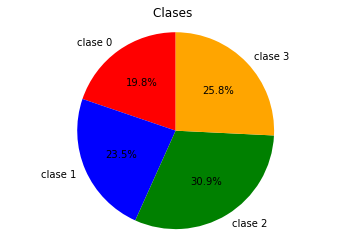

In [343]:
labels = ['clase 0', 'clase 1', 'clase 2', 'clase 3']

s0 = usuarios_descripcion[ (usuarios_descripcion.clase_kmodes == 0)].shape[0]
s1 = usuarios_descripcion[ (usuarios_descripcion.clase_kmodes == 1)].shape[0]
s2 = usuarios_descripcion[ (usuarios_descripcion.clase_kmodes == 2)].shape[0]
s3 = usuarios_descripcion[ (usuarios_descripcion.clase_kmodes == 3)].shape[0]


sizes = [s0,s1,s2,s3]
colors = ['r','b','g','orange']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')
plt.title('Clases ')
plt.savefig('usuarios_cantidad_por_clase'+str(clase)+'.png',format='png')

788
936
1233
1027


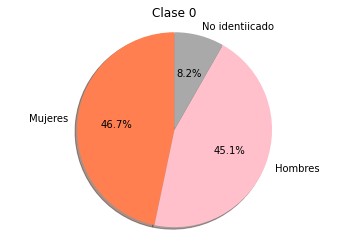

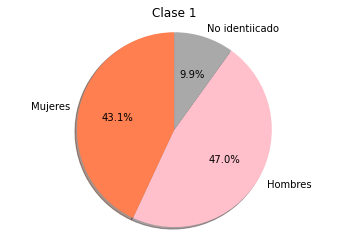

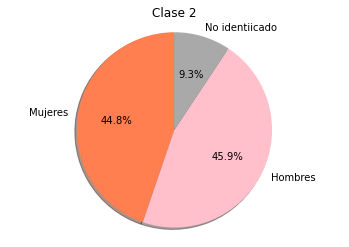

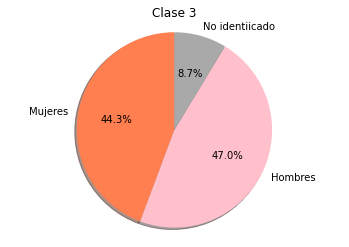

In [349]:
for clase in [0,1,2,3]:
    
    labels = ['Mujeres','Hombres','No identiicado']
    
    s1 = usuarios_descripcion[(usuarios_descripcion.clase_kmodes == clase) &(usuarios_descripcion.genero == 'F')].shape[0]
    s2 = usuarios_descripcion[(usuarios_descripcion.clase_kmodes == clase)&(usuarios_descripcion.genero == 'M')].shape[0]
    s3 = usuarios_descripcion[(usuarios_descripcion.clase_kmodes == clase) &(usuarios_descripcion.genero == 'N')].shape[0]
    
    print(s1+s2+s3)
    
    sizes = [s1,s2,s3]
    colors = ['coral','pink','darkgray']
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    ax1.axis('equal')
    plt.title('Clase '+str(clase))
    plt.savefig('usuarios_genero_por_clase'+str(clase)+'.png',format='png')
    

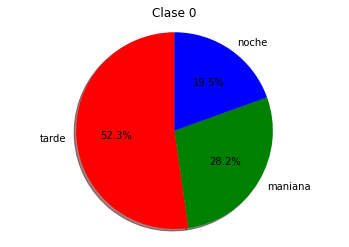

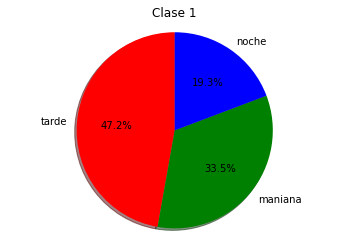

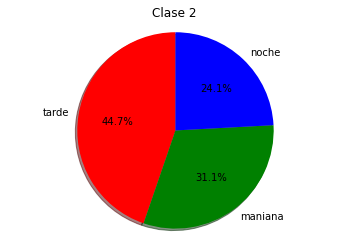

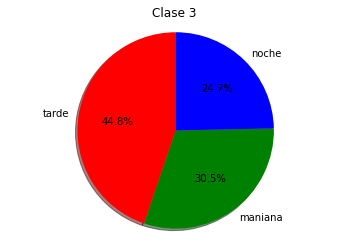

In [316]:
for clase in [0,1,2,3]:
    
    labels = ['tarde','maniana','noche']
    
    s1 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].tarde_transacciones.sum()
    s2 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].maniana_transacciones.sum()
    s3 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].noche_transacciones.sum()
    
    sizes = [s1,s2,s3]
    colors = ['r','g','b']
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    ax1.axis('equal')
    plt.title('Clase '+str(clase))
    plt.savefig('usuarios_horarios_por_clase'+str(clase)+'.png',format='png')
    

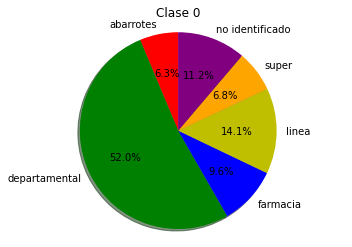

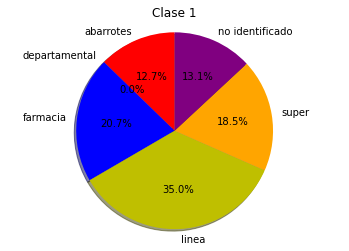

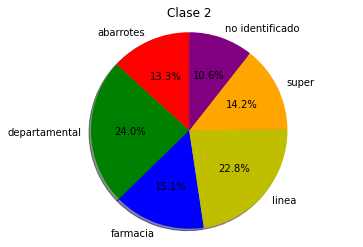

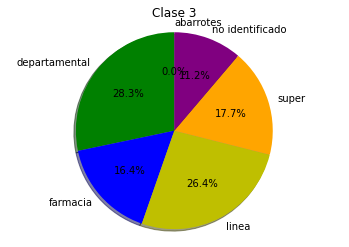

In [311]:
for clase in [0,1,2,3]:
    
    labels = ['abarrotes','departamental','farmacia','linea','super','no identificado']
    
    s1 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].abarrotes_transacciones.sum()
    s2 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].departamental_transacciones.sum()
    s3 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].farmacia_transacciones.sum()
    s4 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].linea_transacciones.sum()
    s5 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].supermercado_transacciones.sum()
    s6 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].transaction_id.sum()-s1-s2-s3-s4-s5
    
    sizes = [s1,s2,s3,s4,s5,s6]
    colors = ['r','g','b','y','orange','purple']
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, colors=colors)
    ax1.axis('equal')
    plt.title('Clase '+str(clase))
    plt.savefig('usuarios_habitos_clase'+str(clase)+'.png',format='png')
    

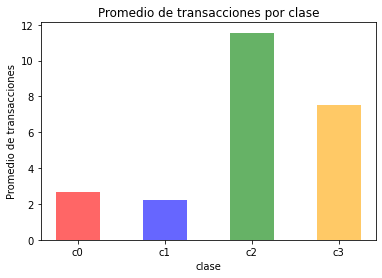

In [312]:
m0 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 0].transaction_id.mean()
m1 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 1].transaction_id.mean()
m2 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 2].transaction_id.mean()
m3 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 3].transaction_id.mean()

fig, ax = plt.subplots()
ax.bar(['c0','c1','c2','c3'], [m0,m1,m2,m3], color=['r','b','g','orange'],alpha=0.6, width=0.5)
ax.set_ylabel('Promedio de transacciones')
ax.set_xlabel('clase')

ax.set_title('Promedio de transacciones por clase')
plt.savefig('RappiCard_usuarios_promedio_transacciones_por_clase.png',format='png')

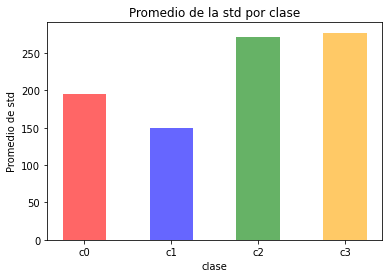

In [313]:
m0 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 0].monto_std.mean()
m1 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 1].monto_std.mean()
m2 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 2].monto_std.mean()
m3 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 3].monto_std.mean()

fig, ax = plt.subplots()
ax.bar(['c0','c1','c2','c3'], [m0,m1,m2,m3], color=['r','b','g','orange'],alpha=0.6, width=0.5)
ax.set_ylabel('Promedio de std')
ax.set_xlabel('clase')

ax.set_title('Promedio de la std por clase')
plt.savefig('RappiCard_usuarios_promedio_monto_std_por_clase.png',format='png')

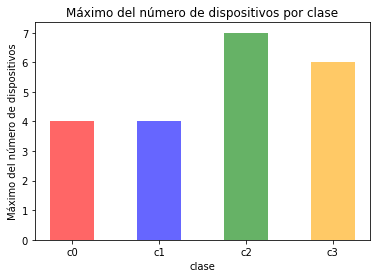

In [314]:
m0 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 0].dispositivo.max()
m1 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 1].dispositivo.max()
m2 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 2].dispositivo.max()
m3 = usuarios_descripcion[usuarios_descripcion.clase_kmodes == 3].dispositivo.max()

fig, ax = plt.subplots()
ax.bar(['c0','c1','c2','c3'], [m0,m1,m2,m3], color=['r','b','g','orange'],alpha=0.6, width=0.5)
ax.set_ylabel('Máximo del número de dispositivos')
ax.set_xlabel('clase')

ax.set_title('Máximo del número de dispositivos por clase')
plt.savefig('RappiCard_usuarios_maximo_numero_dispositivos_por_clase.png',format='png')

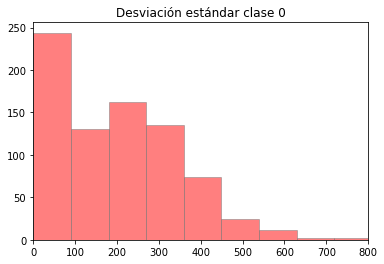

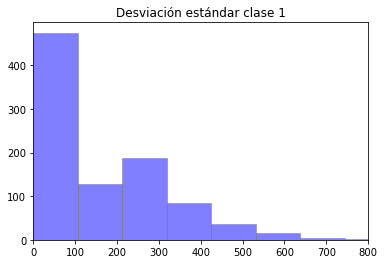

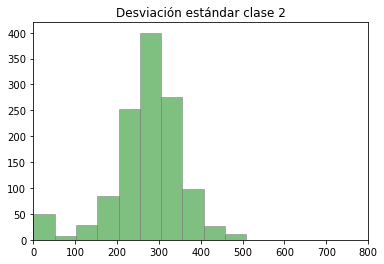

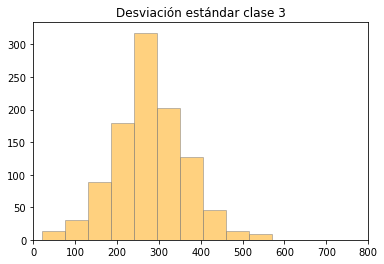

In [315]:
colores = ['r','b','g','orange']
for clase in [0,1,2,3]:
    
    fig, ax = plt.subplots( )
    ax.hist(usuarios_descripcion[usuarios_descripcion.clase_kmodes == clase].monto_std.values, color=colores[clase],edgecolor='gray',alpha=0.5)
    ax.set_xlim([0,800])
    ax.set_title('Desviación estándar clase '+str(clase))
    #plt.savefig('usuarios_transacciones_clase_'+str(clase)+'.png',format='png')

## Fraudes

In [317]:
fraudes = usuarios[usuarios.fraude == True].groupby(['user_id'],as_index=False).agg({'fraudes':sum,'monto':'mean'})
fraudes = fraudes.rename(columns={'monto':'monto_fraude'})

In [321]:
usuarios_descripcion = usuarios_descripcion.merge(fraudes, on='user_id',how='outer')
print(usuarios_descripcion.shape)

(4000, 128)


Ususarios con algún fraude en la clase 0  86.0
Ususarios con algún fraude en la clase 1  76.0
Ususarios con algún fraude en la clase 2  399.0
Ususarios con algún fraude en la clase 3  232.0
Ususarios con algún fraude totales:  793.0


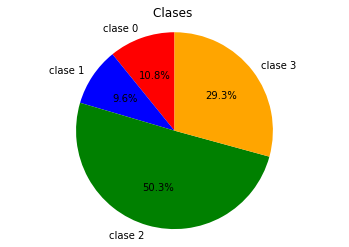

In [362]:
labels = ['clase 0', 'clase 1', 'clase 2', 'clase 3']

s0 = usuarios_descripcion[(~usuarios_descripcion.fraudes.isnull()) & (usuarios_descripcion.clase_kmodes == 0)].fraudes.sum()#[0]
s1 = usuarios_descripcion[(~usuarios_descripcion.fraudes.isnull()) & (usuarios_descripcion.clase_kmodes == 1)].fraudes.sum()
s2 = usuarios_descripcion[(~usuarios_descripcion.fraudes.isnull()) & (usuarios_descripcion.clase_kmodes == 2)].fraudes.sum()
s3 = usuarios_descripcion[(~usuarios_descripcion.fraudes.isnull()) & (usuarios_descripcion.clase_kmodes == 3)].fraudes.sum()

print('Ususarios con algún fraude en la clase 0 ', s0)
print('Ususarios con algún fraude en la clase 1 ', s1)
print('Ususarios con algún fraude en la clase 2 ', s2)
print('Ususarios con algún fraude en la clase 3 ', s3)
print('Ususarios con algún fraude totales: ' , s0+s1+s2+s3)

sizes = [s0,s1,s2,s3]
colors = ['r','b','g','orange']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
ax1.axis('equal')
plt.title('Clases ')
plt.savefig('usuarios_numero_de_fraudes_por_clase'+str(clase)+'.png',format='png')

In [365]:
usuarios_descripcion.to_csv('caracteristicas_usuarios.csv',index=False)